In [13]:
import pandas as pd 

X_train = pd.read_csv("/Users/janma/Desktop/SpaceAppsExoplanets/src/backend/datasets/kepler/X_train_imputed_scaled.csv", index_col=0)
X_test = pd.read_csv("/Users/janma/Desktop/SpaceAppsExoplanets/src/backend/datasets/kepler/X_test_imputed_scaled.csv",  index_col=0)
y_train = pd.read_csv("/Users/janma/Desktop/SpaceAppsExoplanets/src/backend/datasets/kepler/y_train.csv", index_col=0)["label"]
y_test = pd.read_csv("/Users/janma/Desktop/SpaceAppsExoplanets/src/backend/datasets/kepler/y_test.csv",  index_col=0)["label"]
groups = pd.read_csv("/Users/janma/Desktop/SpaceAppsExoplanets/src/backend/datasets/kepler/groups.csv", index_col=0)["kepid"]

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def plot_metrics_vs_threshold(y_true, y_proba, title="Metrics vs Threshold"):
    """Plot accuracy, precision, recall, and F1 while sweeping the decision threshold 0..1."""
    thresholds = np.linspace(0.0, 1.0, 501)
    accs, precs, recs, f1s = [], [], [], []
    for t in thresholds:
        y_pred = (y_proba >= t).astype(int)
        accs.append(accuracy_score(y_true, y_pred))
        precs.append(precision_score(y_true, y_pred, zero_division=0))
        recs.append(recall_score(y_true, y_pred, zero_division=0))
        f1s.append(f1_score(y_true, y_pred, zero_division=0))

    plt.figure(figsize=(8,5))
    plt.plot(thresholds, accs, label="Accuracy")
    plt.plot(thresholds, precs, label="Precision")
    plt.plot(thresholds, recs, label="Recall")
    plt.plot(thresholds, f1s, label="F1")
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.ylim(0, 1.05)
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

In [ ]:
from sklearn.model_selection import StratifiedGroupKFold, cross_validate
from sklearn.linear_model import LogisticRegression

kf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
model = LogisticRegression()
score = cross_validate(model, X_train, y_train, cv=kf, scoring="average_precision", n_jobs=-1, groups=groups)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"F1: {f1_score(y_test, y_pred)}")
print(f"Score: {score}")

Accuracy: 0.7784974093264249
Precision: 0.697171381031614
Recall: 0.7236614853195165
F1: 0.7101694915254237
Score: {'fit_time': array([0.00642514, 0.00630593, 0.00571179, 0.00546789, 0.0102489 ]), 'score_time': array([0.00312591, 0.0013051 , 0.00097513, 0.00097203, 0.00126624]), 'test_score': array([0.76683219, 0.78259986, 0.78620911, 0.7919157 , 0.77995097])}


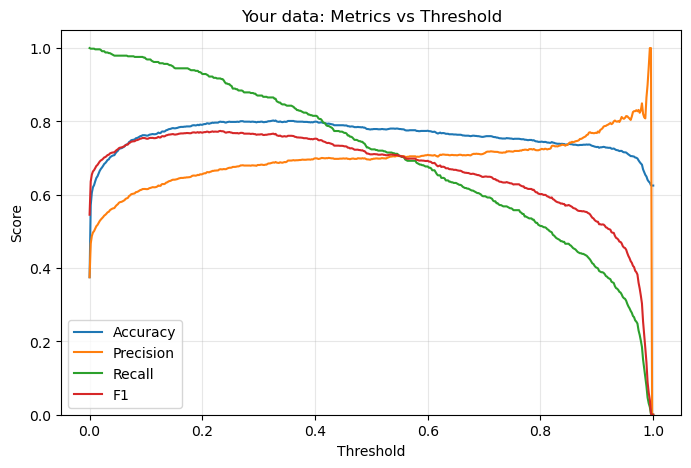

In [16]:
y_1 = model.predict_proba(X_test)[:, 1]

plot_metrics_vs_threshold(y_test, y_1, title="Your data: Metrics vs Threshold")

In [ ]:
from sklearn.model_selection import GridSearchCV

C_small = [1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 3e-2, 1e-1, 0.3, 1.0]

param_grid = {
    "solver": ["lbfgs"],
    "penalty": ["l2"],
    "C": [1e-3, 3e-3, 1e-2, 3e-2, 0.1, 0.3, 1.0],
    "class_weight": [None, "balanced"],
    "max_iter": [5000],
    "tol": [1e-4],
}

models_cv = GridSearchCV(LogisticRegression(), param_grid=param_grid, scoring="average_precision", cv=kf, refit=True, verbose = 1)
models_cv.fit(X_train, y_train, groups=groups)

best_model = models_cv.best_estimator_ 
print("Best PR-AUC:", models_cv.best_score_)
print("Best params:", models_cv.best_params_)

Fitting 5 folds for each of 14 candidates, totalling 70 fits
Best PR-AUC: 0.7815015641664139
Best params: {'C': 1.0, 'class_weight': None, 'max_iter': 5000, 'penalty': 'l2', 'solver': 'lbfgs', 'tol': 0.0001}


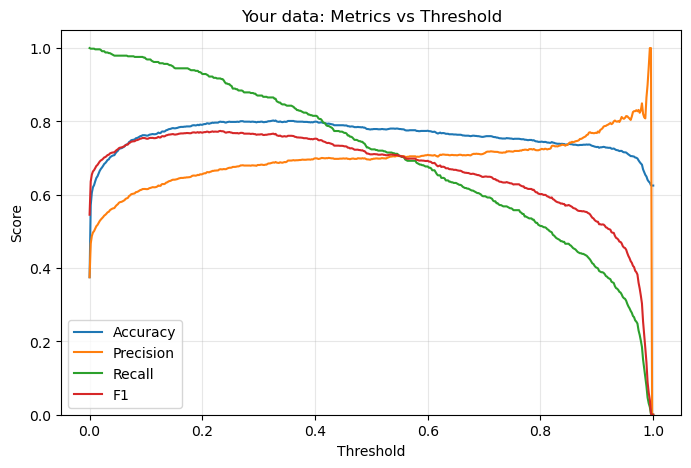

In [23]:
y_2 = best_model.predict_proba(X_test)[:, 1]

plot_metrics_vs_threshold(y_test, y_2, title="Your data: Metrics vs Threshold")

In [28]:
import numpy as np 
from sklearn.metrics import confusion_matrix

thresholds = np.linspace(0.0, 1.0, 101)  
rows = []
for thr in thresholds:
    y_hat = (y_2 >= thr).astype(int)
    p = precision_score(y_test, y_hat, zero_division=0)
    r = recall_score(y_test, y_hat, zero_division=0)
    f1 = f1_score(y_test, y_hat, zero_division=0)
    rows.append((thr, p, r, f1))

cand = [(thr, p, r, f1) for (thr, p, r, f1) in rows if f1 >= 0.80]
if cand:
    thr_star, p_star, r_star, f1 = max(cand, key=lambda x: x[2]) 
else:
    thr_star, p_star, r_star, f1 = 0.5, None, None, None

print(f"Chosen threshold: {thr_star:.3f}  (F1 ≥ 0.80)")
y_pred_thr = (y_2 >= thr_star).astype(int)
print("Precision/Recall/F1 @ thr:", 
      precision_score(y_test, y_pred_thr), 
      recall_score(y_test, y_pred_thr),
      f1_score(y_test, y_pred_thr))
print(confusion_matrix(y_test, y_pred_thr))

Chosen threshold: 0.500  (F1 ≥ 0.80)
Precision/Recall/F1 @ thr: 0.697171381031614 0.7236614853195165 0.7101694915254237
[[783 182]
 [160 419]]


In [ ]:
from pathlib import Path
import joblib

ARTS = Path("/Users/janma/Desktop/SpaceAppsExoplanets/src/backend/saved-models/kepler")
ARTS.mkdir(parents=True, exist_ok=True)

In [35]:
bundle1 = {
    "model": model,            
    "threshold": 0.5,              
}

joblib.dump(bundle1, ARTS / "kepler_LR_v1.joblib")
print("Saved →", ARTS / "kepler_LR_v1.joblib")

Saved → /Users/janma/Desktop/SpaceAppsExoplanets/src/backend/saved-models/kepler/kepler_LR_v1.joblib


In [36]:
bundle2 = {
    "model": best_model,            
    "threshold": thr_star,              
}

joblib.dump(bundle2, ARTS / "kepler_LR_best_v1.joblib")
print("Saved →", ARTS / "kepler_LR_best_v1.joblib")

Saved → /Users/janma/Desktop/SpaceAppsExoplanets/src/backend/saved-models/kepler/kepler_LR_best_v1.joblib
